# Funkcje Aktywacji i Funkcje Straty

W tym notatniku porządkujemy podstawowe pojęcia dotyczące funkcji aktywacji oraz funkcji straty w sieciach neuronowych. Zobaczysz, kiedy stosować konkretne aktywacje, jak dobrać funkcję straty do problemu oraz jak poprawnie łączyć oba elementy w warstwie wyjściowej modeli tworzonych w PyTorch i TensorFlow.

## Czym jest funkcja aktywacji?

Neuron najpierw oblicza liniową kombinację wejść \(z = \mathbf{w}^\top \mathbf{x} + b\), a następnie przepuszcza wynik przez nieliniową funkcję aktywacji \(a = f(z)\). Dzięki temu sieci neuronowe:

- wprowadzają nieliniowość, co pozwala modelować złożone zależności,
- ograniczają zakres wartości (np. do \[0, 1\] lub \[-1, 1\]),
- stabilizują uczenie poprzez kontrolę gradientów i zapobieganie eksplozji wartości.

Bez funkcji aktywacji wielowarstwowa sieć redukowałaby się do pojedynczego modelu liniowego.

## Przegląd popularnych funkcji aktywacji

| Funkcja        | Wzór $$f(x)$$                                                               | Pochodna $$f'(x)$$                                                     | Uwagi                                                          |
| -------------- | --------------------------------------------------------------------------- | ---------------------------------------------------------------------- | -------------------------------------------------------------- |
| **Step**       | $$f(x) = \begin{cases}0 & x<0 \\ 1 & x \ge 0 \end{cases}$$                 | brak (stała 0, nieróżniczkowalna w $$x=0$$)                           | Historyczna, dziś nieużywana                                   |
| **Sigmoid**    | $$f(x) = \sigma(x) = \frac{1}{1+e^{-x}}$$                                   | $$f'(x) = \sigma(x)\cdot(1-\sigma(x))$$                               | Dobre do wyjścia binarnego, ale cierpi na *vanishing gradient* |
| **tanh**       | $$f(x) = \tanh(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}}$$                        | $$f'(x) = 1 - \tanh^2(x)$$                                            | Zero-centrowana, lepsza od sigmoid, używana w RNN              |
| **ReLU**       | $$f(x) = \max(0, x)$$                                                       | $$f'(x) = \begin{cases}0 & x<0 \\ 1 & x>0 \end{cases}$$               | Domyślna w CNN/MLP, problem „martwych neuronów”                |
| **Leaky ReLU** | $$f(x) = \begin{cases}x & x>0 \\ \alpha x & x \le 0 \end{cases}$$          | $$f'(x) = \begin{cases}1 & x>0 \\ \alpha & x \le 0 \end{cases}$$      | Łagodzi problem martwych neuronów, $$\alpha$$ to hiperparametr  |
| **ELU**        | $$f(x) = \begin{cases}x & x \ge 0 \\ \alpha(e^x - 1) & x < 0 \end{cases}$$ | $$f'(x) = \begin{cases}1 & x \ge 0 \\ f(x)+\alpha & x<0 \end{cases}$$ | Średnia aktywacja bliżej 0, stabilniejsze uczenie              |
| **Swish**      | $$f(x) = x \cdot \sigma(x) = \frac{x}{1+e^{-x}}$$                          | $$f'(x) = \sigma(x) + f(x)\cdot(1-\sigma(x))$$                        | Często skuteczniejsza niż ReLU (np. EfficientNet)              |
| **Softmax**    | $$f_i(\mathbf{z}) = \frac{e^{z_i}}{\sum_j e^{z_j}}$$                       | $$\frac{\partial f_i}{\partial z_j} = f_i(\delta_{ij} - f_j)$$        | Zamienia logity na rozkład prawdopodobieństwa w klasach        |


## Jak dobierać funkcję aktywacji w warstwach ukrytych?

- **Domyślna opcja:** ReLU lub jej warianty (Leaky ReLU, GELU) w większości sieci feedforward i konwolucyjnych.
- **Dane znormalizowane wokół zera:** tanh może przyspieszyć uczenie, ale cierpi na zanikanie gradientów.
- **Sieci rekurencyjne:** obecnie stosuje się głównie bramkowane jednostki (LSTM/GRU). Gdy definiujesz własne komórki, często spotkasz tanh (stan) oraz sigmoid (bramki).
- **Sieci bardzo głębokie / Transformers:** popularne są nowsze funkcje (GELU, Swish) zapewniające gładkie gradienty.

<div class="alert alert-info">
    Bramkowane jednostki (gated units) to specjalne warianty komórek RNN, które wprowadzają mechanizm bramek (gates) – czyli dodatkowych funkcji kontrolujących przepływ informacji.

Zwykłe RNN mają problem z zanikającym gradientem – trudno im uczyć się długich zależności. Bramki rozwiązują ten problem, bo pozwalają sieci decydować, co pamiętać, a co zapomnieć.
</div>

W warstwach wyjściowych funkcję aktywacji dobieramy do rodzaju problemu i funkcji straty – temu poświęcona jest kolejna sekcja.

## Czym jest funkcja straty?

Funkcja straty (loss function) mierzy, jak bardzo prognozy modelu różnią się od oczekiwanych etykiet. To właśnie minimalizację funkcji straty optymalizuje algorytm uczenia. Dobra funkcja straty powinna:

- być różniczkowalna (lub prawie wszędzie różniczkowalna),
- dobrze odzwierciedlać cel zadania (np. regresja vs klasyfikacja),
- dostarczać użytecznych gradientów – zbyt „płaskie” funkcje utrudniają uczenie.

Przykładowo w regresji często używamy średniego błędu kwadratowego (MSE), a w klasyfikacji – entropii krzyżowej (cross-entropy).

## Dobór funkcji straty do typu problemu

| Typ zadania                               | Wyjście modelu                | Aktywacja końcowa           | PyTorch (przykład)                    | TensorFlow (przykład)                                        | Uwagi                                                                 |
| ----------------------------------------- | ----------------------------- | --------------------------- | ------------------------------------- | ------------------------------------------------------------ | --------------------------------------------------------------------- |
| Regresja ciągła (1/ wiele zmiennych)      | Wartości rzeczywiste          | Brak (warstwa liniowa)      | `nn.MSELoss`, `nn.L1Loss`, `nn.SmoothL1Loss` | `MeanSquaredError`, `MeanAbsoluteError`, `Huber`               | Opcjonalnie można ograniczać zakres przy pomocy $\tanh$ lub $\sigma$.    |
| Klasyfikacja binarna (jeden neuron)       | Logity $$\mathbb{R}$$         | Brak lub `Sigmoid`          | `nn.BCEWithLogitsLoss` (bez aktywacji) <br>`nn.BCELoss` + `Sigmoid` | `BinaryCrossentropy(from_logits=True)` <br>`BinaryCrossentropy` + `sigmoid` | Wariant z logitami jest stabilniejszy numerycznie.                    |
| Klasyfikacja wieloklasowa (mutual exclusive) | Logity $$\mathbb{R}^K$$      | Softmax (jawnie lub w stracie) | `nn.CrossEntropyLoss` (bez jawnej softmax) | `SparseCategoricalCrossentropy(from_logits=True)` lub `CategoricalCrossentropy` + `softmax` | `CrossEntropyLoss` łączy `LogSoftmax` i NLL w jednym kroku.          |
| Klasyfikacja wieloetykietowa (multi-label) | Logity $$\mathbb{R}^K$$      | Sigmoid (na każdy neuron)   | `nn.BCEWithLogitsLoss`                 | `BinaryCrossentropy(from_logits=True)`                       | Każda etykieta jest niezależna – stosujemy sigmoid na każdym wyjściu. |
| Modele językowe / sekwencyjne             | Logity $$\mathbb{R}^V$$      | Softmax (często implicit)   | `nn.CrossEntropyLoss`                  | `SparseCategoricalCrossentropy(from_logits=True)`            | Tak samo jak w klasyfikacji wieloklasowej, ale na każdym kroku sekwencji. |



## Logity – co to jest?

**Logity** (*logits*) to **surowe wyjścia modelu** przed zastosowaniem funkcji aktywacji typu sigmoid albo softmax.
To po prostu wartości z ostatniej warstwy liniowej (np. `Dense` albo `Linear`) – mogą być dowolnymi liczbami rzeczywistymi: dodatnimi, ujemnymi, bardzo dużymi albo bardzo małymi.

---

### Dlaczego się je stosuje?

1. **Stabilność numeryczna** – obliczanie straty bezpośrednio na logitach (np. `BCEWithLogitsLoss`, `CrossEntropyLoss`) jest bardziej stabilne niż gdy najpierw zastosujemy softmax/sigmoid, a potem log.
2. **Łatwość interpretacji** – logity są proporcjonalne do log-szans:

   * dla klasyfikacji binarnej:
     $$
     \text{logit}(p) = \log \frac{p}{1-p}
     $$
     czyli odwrotność sigmoidu.
   * duży dodatni logit → model pewny, że klasa to „1”
   * duży ujemny logit → model pewny, że klasa to „0”
3. **Łączenie z funkcją straty** – np. w PyTorch `CrossEntropyLoss` automatycznie robi `LogSoftmax` + `NLLLoss` na logitach.

---

### Intuicja

* Logit to **„nieprzetworzone zdanie modelu”**.
* Dopiero po przepuszczeniu przez **sigmoid** (dla 0/1) lub **softmax** (dla wielu klas) otrzymujemy **prawdopodobieństwa**.

---

🔎 Przykład:
Model przewidział logity `[2.0, -1.0, 0.5]`.

* Po softmax: $$[0.71, 0.06, 0.23]$$ → interpretujemy jako prawdopodobieństwa klas.

---

### jak logity zamieniają się w prawdopodobieństwa przez sigmoid i softmax?


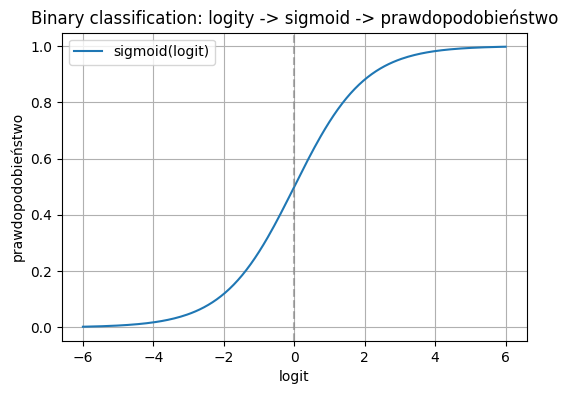

Logity:
[[ 2.   1.   0.1]
 [ 0.   0.   0. ]
 [-1.   3.   0.5]]

Softmax -> prawdopodobieństwa:
[[0.65900114 0.24243297 0.09856589]
 [0.33333333 0.33333333 0.33333333]
 [0.01664452 0.90875992 0.07459556]]


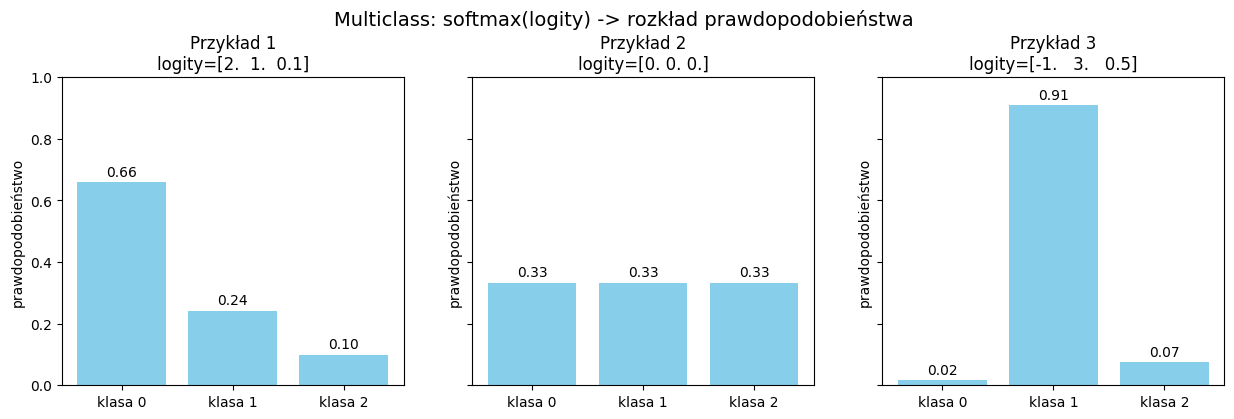

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Binary case: sigmoid ---
logits = np.linspace(-6, 6, 200)
sigmoid = 1 / (1 + np.exp(-logits))

plt.figure(figsize=(6,4))
plt.plot(logits, sigmoid, label="sigmoid(logit)")
plt.title("Binary classification: logity -> sigmoid -> prawdopodobieństwo")
plt.xlabel("logit")
plt.ylabel("prawdopodobieństwo")
plt.axvline(0, color="gray", linestyle="--", alpha=0.6)
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Multiclass case: softmax ---
logits = np.array([
    [2.0, 1.0, 0.1],
    [0.0, 0.0, 0.0],
    [-1.0, 3.0, 0.5]
])

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # stabilizacja
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

probs = softmax(logits)

print("Logity:")
print(logits)
print("\nSoftmax -> prawdopodobieństwa:")
print(probs)

# --- 3. Wykresy dla wszystkich przykładów ---
classes = ["klasa 0", "klasa 1", "klasa 2"]

fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)

for i, ax in enumerate(axes):
    ax.bar(classes, probs[i], color="skyblue")
    ax.set_ylim(0,1)
    ax.set_ylabel("prawdopodobieństwo")
    # dodajemy wartości nad słupkami
    for j, p in enumerate(probs[i]):
        ax.text(j, p+0.02, f"{p:.2f}", ha="center", fontsize=10)
    # tytuł z logitami
    ax.set_title(f"Przykład {i+1}\nlogity={logits[i]}")

plt.suptitle("Multiclass: softmax(logity) -> rozkład prawdopodobieństwa", fontsize=14, y=1.05 )
plt.show()


## Wybrane funkcje straty

### Binary Cross Entropy (BCE)

#### Definicja

Funkcja straty używana w **klasyfikacji binarnej**.
Porównuje **prawdziwą etykietę** $y \in {0,1}$ z **przewidywanym prawdopodobieństwem** $\hat{y} \in (0,1)$ (np. z sigmoidu).

$$
\text{BCE}(y, \hat{y}) = -\Big( y \log(\hat{y}) + (1-y) \log(1-\hat{y}) \Big)
$$

---

#### Intuicja

* Jeśli $y=1$, kara rośnie gdy model daje $\hat{y}$ bliskie 0.
* Jeśli $y=0$, kara rośnie gdy model daje $\hat{y}$ bliskie 1.
* Minimum osiąga wtedy, gdy $\hat{y}$ dobrze odwzorowuje prawdziwe $y$.

👉 BCE = **ile „kosztuje” nasz błąd, mierzony w jednostkach informacji**.

---

#### Przykład

Dla $y=1$:

* $\hat{y}=0.9$ → $\text{BCE} \approx 0.105$ (mała kara, dobra predykcja)
* $\hat{y}=0.1$ → $\text{BCE} \approx 2.303$ (duża kara, zła predykcja)

---

📌 **Podsumowanie**: Binary Cross Entropy mierzy różnicę między **prawdziwym rozkładem Bernoulliego** (etykieta) a **przewidywanym rozkładem** (sigmoid output). Im bliżej $\hat{y}$ do $y$, tym mniejsza strata.

---

#### Prosty kod

In [32]:
import numpy as np

def binary_cross_entropy(y_true, y_pred):
    # dodajemy epsilon dla stabilności numerycznej (żeby nie brać log(0))
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# przykłady
cases = [
    (1, 0.9),   # prawidłowe przewidywanie dla klasy 1
    (1, 0.1),   # błędne przewidywanie dla klasy 1
    (0, 0.1),   # prawidłowe przewidywanie dla klasy 0
    (0, 0.9)    # błędne przewidywanie dla klasy 0
]

for y, yhat in cases:
    loss = binary_cross_entropy(y, yhat)
    print(f"y={y}, y_hat={yhat:.1f} -> BCE = {loss:.3f}")

y=1, y_hat=0.9 -> BCE = 0.105
y=1, y_hat=0.1 -> BCE = 2.303
y=0, y_hat=0.1 -> BCE = 0.105
y=0, y_hat=0.9 -> BCE = 2.303


---

👉 Widać, że **dobrze trafione predykcje** dają małą stratę, a **pewne, ale błędne przewidywania** karane są bardzo mocno.

### Mean Squared Error (MSE)

#### Definicja

Funkcja straty używana głównie w **regresji**.
Porównuje **prawdziwą wartość** $y \in \mathbb{R}$ z **przewidywaną wartością** $\hat{y} \in \mathbb{R}$.

$$
\text{MSE}(y, \hat{y}) = (y - \hat{y})^2
$$

Dla całego zbioru danych (średnia ze wszystkich przykładów):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2
$$

---

#### Kod

In [33]:
import numpy as np

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# przykłady
cases = [
    (3.0, 2.5),  # przewidywanie blisko prawdy
    (3.0, 0.0),  # duży błąd w dół
    (3.0, 5.0)   # duży błąd w górę
]

for y, yhat in cases:
    loss = mean_squared_error(np.array([y]), np.array([yhat]))
    print(f"y={y}, y_hat={yhat:.1f} -> MSE = {loss:.3f}")

y=3.0, y_hat=2.5 -> MSE = 0.250
y=3.0, y_hat=0.0 -> MSE = 9.000
y=3.0, y_hat=5.0 -> MSE = 4.000


---

#### Intuicja

* Kara rośnie proporcjonalnie do **kwadratu różnicy**.
* Małe błędy → bardzo mała kara.
* Duże błędy → kara rośnie szybko (bo kwadrat).
* Minimum osiąga wtedy, gdy $\hat{y}$ równa się $y$.

👉 MSE = **średni kwadratowy koszt błędu**.

---

#### Przykład

Dla $y=3.0$:

* $\hat{y}=2.5$ → $\text{MSE} = 0.25$ (mały błąd, dobra predykcja)
* $\hat{y}=0.0$ → $\text{MSE} = 9.00$ (duży błąd w dół)
* $\hat{y}=5.0$ → $\text{MSE} = 4.00$ (duży błąd w górę)

---

📌 **Podsumowanie**: Mean Squared Error mierzy średnią kwadratową różnicę między wartościami przewidywanymi a rzeczywistymi. Jest wrażliwa na duże błędy (outliery mogą mocno zwiększać wartość straty).



### Categorical Cross Entropy (CCE)

#### Definicja

Funkcja straty używana w **klasyfikacji wieloklasowej**.
Porównuje **prawdziwą etykietę** (zapisana jako *one-hot*) z **przewidywanym rozkładem prawdopodobieństwa** (np. z softmaxa).

Dla jednej próbki:

$$
\text{CCE}(y, \hat{y}) = - \sum_{i=1}^{K} y_i \log(\hat{y}_i)
$$

* $y \in {0,1}^K$ – wektor one-hot prawdziwej klasy
* $\hat{y} \in (0,1)^K$ – przewidywany rozkład prawdopodobieństwa (z softmaxa)

##### KOD
---

In [34]:
import numpy as np

def categorical_cross_entropy(y_true, y_pred):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.sum(y_true * np.log(y_pred))

# przykład: 3 klasy
y_true = np.array([0, 1, 0])   # prawdziwa klasa = 2
y_pred_good = np.array([0.1, 0.8, 0.1])
y_pred_bad = np.array([0.7, 0.2, 0.1])

print("Dobry model:", categorical_cross_entropy(y_true, y_pred_good))
print("Zły model:", categorical_cross_entropy(y_true, y_pred_bad))

Dobry model: 0.2231435513142097
Zły model: 1.6094379124341003


---

#### Intuicja

* Jeśli model przypisuje wysokie prawdopodobieństwo prawdziwej klasie → strata jest mała.
* Jeśli model się „mocno myli” i daje niskie prawdopodobieństwo prawdziwej klasie → kara rośnie bardzo szybko.
* Minimum osiąga wtedy, gdy $\hat{y}$ wskazuje prawdziwą klasę z prawdopodobieństwem bliskim 1.

👉 CCE = **miara tego, jak dobrze rozkład przewidywań zgadza się z rzeczywistą klasą**.

---

#### Przykład

Prawdziwa klasa = 2:

* $\hat{y}=[0.1, 0.8, 0.1]$ → $\text{CCE} \approx 0.223$ (dobra predykcja)
* $\hat{y}=[0.7, 0.2, 0.1]$ → $\text{CCE} \approx 1.609$ (zła predykcja, bo wysoka pewność w złej klasie)

---

📌 **Podsumowanie**: Categorical Cross Entropy mierzy różnicę między **prawdziwą klasą (one-hot)** a **przewidywanym rozkładem (softmax)**. Nagradza pewne trafienia, mocno karze pewne błędy.



## Jak łączyć funkcję aktywacji z funkcją straty w warstwie wyjściowej?

1. **Sprawdź, czy funkcja straty oczekuje logitów, czy wartości po aktywacji.** Przykładowo `nn.CrossEntropyLoss` w PyTorch zakłada, że na wejściu dostaje logity i samodzielnie wykonuje `LogSoftmax`. Jeżeli przed stratą zastosujesz `Softmax`, gradienty będą gorsze (dwa logarytmy) i wyniki mniej stabilne.
2. **Aktywacja i strata powinny współpracować semantycznie.** Dla klasyfikacji binarnej `Sigmoid` tworzy prawdopodobieństwo w \[0, 1\], a `BinaryCrossentropy` mierzy różnicę między rozkładami Bernoulliego.
3. **Pamiętaj o multi-label.** Każde wyjście to niezależna etykieta, więc stosujemy sigmoid per klasa oraz sumę entropii krzyżowych zamiast softmaxu (który wymusza rozkład sumujący się do 1).
4. **W regresji często nie stosujemy aktywacji.** Wyjście liniowe umożliwia prognozowanie dowolnych wartości. Jedynie gdy znamy zakres, możemy dodać `tanh`/`sigmoid` i przeskalować wynik.

W praktyce większość nowoczesnych bibliotek oferuje funkcje straty działające bezpośrednio na logitach, co poprawia stabilność numeryczną i pozwala zrezygnować z aktywacji w warstwie wyjściowej podczas trenowania.

## Wizualizacja wybranych funkcji aktywacji

Poniższy kod generuje wykres porównujący najczęściej spotykane funkcje aktywacji. Dzięki temu szybciej zauważysz ich zakres oraz miejsca, w których gradient może zanikać.

In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
def step_function(x: np.ndarray) -> np.ndarray:
    """
    Binary step: f(x) = 0 if x<0 else 1.
    """
    return np.where(x < 0, 0.0, 1.0)


def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    Logistic sigmoid: f(x) = 1 / (1 + exp(-x))

    Pros:
    - Interpretable as probability.

    Cons:
    - Saturates for |x| >> 0 -> vanishing gradients.
    """
    return 1 / (1 + np.exp(-x))


def tanh(x: np.ndarray) -> np.ndarray:
    """
    Hyperbolic tangent: f(x) = tanh(x)
    """
    return np.tanh(x)


def relu(x: np.ndarray) -> np.ndarray:
    """
    Rectified Linear Unit: f(x) = max(0, x)
    """
    return np.maximum(0, x)


def leaky_relu(x: np.ndarray, alpha: float = 0.1) -> np.ndarray:
    """
    Leaky ReLU: f(x) = x if x>0 else alpha * x
    """
    return np.where(x > 0, x, alpha * x)


def elu(x: np.ndarray, alpha: float = 1.0) -> np.ndarray:
    """
    Exponential Linear Unit: f(x) = x if x>=0 else alpha * (exp(x) - 1)
    """
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))


def swish(x: np.ndarray) -> np.ndarray:
    """
    Swish activation: f(x) = x * sigmoid(x)
    """
    return x * sigmoid(x)

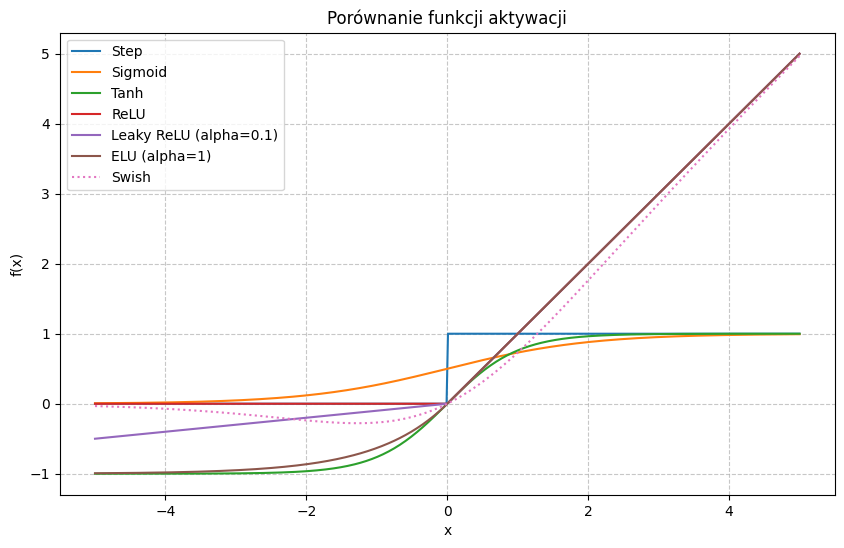

In [37]:
x = np.linspace(-5, 5, 500)

plt.figure(figsize=(10, 6))
plt.plot(x, step_function(x), label="Step")
plt.plot(x, sigmoid(x), label="Sigmoid")
plt.plot(x, tanh(x), label="Tanh")
plt.plot(x, relu(x), label="ReLU")
plt.plot(x, leaky_relu(x), label="Leaky ReLU (alpha=0.1)")
plt.plot(x, elu(x), label="ELU (alpha=1)")
plt.plot(x, swish(x), label="Swish", linestyle=":")

plt.title("Porównanie funkcji aktywacji")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()

## Mini przykład: klasyfikacja binarna w PyTorch

W PyTorch popularne jest trenowanie na logitach i korzystanie z `nn.BCEWithLogitsLoss`, która łączy entropię krzyżową z funkcją sigmoidalną w jednym kroku. Dzięki temu warstwa wyjściowa pozostaje liniowa, a funkcja straty dba o stabilność numeryczną.

In [38]:
import torch
from torch import nn

torch.manual_seed(42)

features = torch.randn(128, 2)
labels = (features[:, 0] + 0.75 * features[:, 1] > 0).float().unsqueeze(1)

model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 1)  # brak aktywacji na wyjściu (logity)
)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

logits = model(features)
loss = criterion(logits, labels)

loss.backward()
optimizer.step()
optimizer.zero_grad(set_to_none=True)

with torch.no_grad():
    probabilities = torch.sigmoid(logits)
    predictions = (probabilities > 0.5).float()
    accuracy = (predictions == labels).float().mean()

print(f"Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.3f}")

Loss: 0.6995, Accuracy: 0.477


## Mini przykład: klasyfikacja binarna w TensorFlow

W Kerasie możesz zdecydować, czy chcesz obliczać prawdopodobieństwo w warstwie wyjściowej (`activation='sigmoid'`) i użyć `BinaryCrossentropy(from_logits=False)`, czy pozostawić warstwę liniową i ustawić `from_logits=True`. Poniżej wariant pierwszy – bardziej intuicyjny na etapie inferencji.

In [39]:
try:
    import tensorflow as tf
except ImportError:
    print("TensorFlow nie jest zainstalowany w tym środowisku.")
else:
    tf.random.set_seed(42)

    inputs = tf.random.normal((128, 2))
    targets = tf.cast(tf.reduce_sum(inputs, axis=1, keepdims=True) > 0.0, tf.float32)

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # aktywacja dopasowana do BinaryCrossentropy
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.01),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    model.fit(inputs, targets, epochs=5, batch_size=32, verbose=0)
    loss, acc = model.evaluate(inputs, targets, verbose=0)
    print(f"Loss: {loss:.4f}, Accuracy: {acc:.3f}")

Loss: 0.4196, Accuracy: 0.969


## Podsumowanie

- Funkcje aktywacji odpowiadają za nieliniowość i stabilność gradientów.
- Funkcje straty determinują, jakie błędy minimalizuje model – dobieramy je do typu zadania.
- W warstwie wyjściowej najważniejsze jest dopasowanie aktywacji do funkcji straty (np. logity + `CrossEntropyLoss`, sigmoid + `BinaryCrossentropy`).
- Zarówno PyTorch, jak i TensorFlow oferują wygodne interfejsy do definiowania sieci, gdzie kryterium i optimizer jasno opisują proces uczenia.